<a href="https://colab.research.google.com/github/AlexTako/AI_practice/blob/main/You_are_Russian_writer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Когда вы еще учились в школе, то вас часто мучали написанием сочинений. Может быть даже кто-нибудь из вас увлекался написанием стихотворений, романов или прозы. А значит, в вас живет дух великого русского писателя. А вот интересно какого? В данной работе мы это и выясним!


1. Скачал датасет с [писателями Русской литературы](https://storage.yandexcloud.net/academy.ai/russian_literature.zip). Каждый текст разбил на обучающую, проверочную и тестовую выборки
2. Выбрал лучший вариант нейронки и адаптировал ее структуру.
3. Подгрузил веса Наташи для слоя эмбендинга.
4. Заморозил слой эмбединга.
5. Обучил модель на писателях с балансировкой.
6. Построил матрицу ошибок на тестовых образцах.
7. Подготовил свой текст и предложил нейронке предсказать на кого из русских писателей похож мой текст.

In [ ]:
from keras.models import Sequential
from keras.utils import get_file, to_categorical
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout, SimpleRNN
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

from keras.preprocessing.text import Tokenizer

import os   # Модуль для работы с файловой системой

import glob # Вспомогательный модуль для работы с файловой системой
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2024-03-15 13:31:23--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.6’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.3MB/s    in 4.2s    

2024-03-15 13:31:28 (12.1 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.6’ saved [53012480/53012480]



In [ ]:
!pip install navec

In [ ]:
from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:

data_path = get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
)
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "{data_path}" -d ./dataset

FILE_DIR_POEMS = './dataset/poems'
file_list_poems = os.listdir(FILE_DIR_POEMS)

FILE_DIR_PROSE = './dataset/prose'
file_list_prose = os.listdir(FILE_DIR_PROSE)

CLASS_LIST = list(set(file_list_poems + file_list_prose))

all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
    all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
        with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
            # Загрузка содержимого файла в строку
            text = f.read()

        all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Ф╨╛╨║╨╗╨░╨┤, ╨┐╤А╨╕╨│╨╛╤В╨╛╨▓╨╗╨╡╨╜╨╜╤Л╨╣ ╨┤╨╗╤П ╨║╨╛╨╜╨│╤А╨╡╤Б╤Б╨░ ╨╛ ╨╝╨╕╤А╨╡ ╨▓ ╨б╤В╨╛╨║╨│╨╛╨╗╤М╨╝╨╡.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Я╨╛╤З╨╡╨╝╤Г ╤Е╤А╨╕╤Б╤В╨╕╨░╨╜╤Б╨║╨╕╨╡ ╨╜╨░╤А╨╛╨┤╤Л ╨▓╨╛╨╛╨▒╤Й╨╡ ╨╕ ╨▓ ╨╛╤Б╨╛╨▒╨╡╨╜╨╜╨╛╤Б╤В╨╕ ╤А╤Г╤Б╤Б╨║╨╕╨╣ ╨╜╨░╤Е╨╛╨┤╤П╤В╤Б╤П ╤В╨╡╨┐╨╡╤А╤М ╨▓ ╨▒╨╡╨┤╤Б╤В╨▓╨╡╨╜╨╜╨╛╨╝ ╨┐╨╛╨╗╨╛╨╢╨╡╨╜╨╕╨╕.txt
        File name too long


In [ ]:
embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 15000      # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False)


# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

In [ ]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())

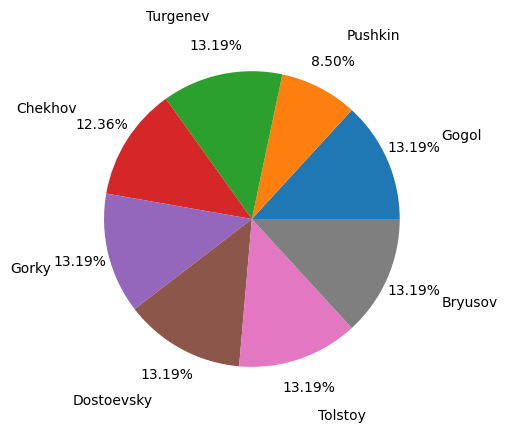

In [ ]:
total = sum(len(i) for i in seq_train)
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    mean_list = np.append(mean_list, len(seq_train[cls]))

median = int(np.median(mean_list)) # Зафиксировали медианное значение
CLASS_LIST_BALANCE = [] # Сбалансированный набор меток
seq_train_balance = []
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    if len(seq_train[cls]) > median * 0.6:
      seq_train_balance.append(seq_train[cls][:median])
      CLASS_LIST_BALANCE.append(author)

fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance],  # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_BALANCE,            # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую выборку
    validation_split, # Доля на проверочную выборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test, x_valid, y_valid =  [], [], [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1-(test_split+validation_split)))
        valid_split = int(len(seq_list[cls]) * (1-validation_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:valid_split], win_size, step)
        vectors_validation = seq_split(seq_list[cls][valid_split:], win_size, step)

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test
        x_valid += vectors_validation

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [to_categorical(cls, len(class_list))] * len(vectors_test)
        y_valid += [to_categorical(cls, len(class_list))] * len(vectors_validation)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test), np.array(x_valid), np.array(y_valid)

In [ ]:
x_train, y_train, x_test, y_test, x_valid, y_valid = seq_vectorize(seq_train_balance, 0.1, 0.1, CLASS_LIST_BALANCE, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (15766, 1000)
Форма выходных данных (меток) для обучающей выборки: (15766, 8)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (1906, 1000)
Форма выходных данных (меток) для тестовой выборки: (1906, 8)


In [ ]:
print(f'Форма входных данных для проверочной выборки: {x_valid.shape}')
print(f'Форма выходных данных (меток) для проверочной выборки: {y_valid.shape}')

Форма входных данных для проверочной выборки: (1906, 1000)
Форма выходных данных (меток) для проверочной выборки: (1906, 8)


In [ ]:
# Вывод графиков точности и ошибки
def show_plot(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели: '+title)
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Грузим веса Наташи
def loadEmbedding(model):
    word_index = tokenizer.word_index
    embeddings_index = navec

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    return model

In [ ]:
model_MIX = Sequential()
model_MIX.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_MIX.add(SpatialDropout1D(0.3))
model_MIX.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Два рекуррентных слоя GRU
model_MIX.add(GRU(16, return_sequences=True, reset_after=True))
model_MIX.add(GRU(16, reset_after=True))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Дополнительный полносвязный слой
model_MIX.add(Dense(100, activation='relu'))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())
model_MIX.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
model_MIX = loadEmbedding(model_MIX)

In [ ]:
model_MIX.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mix = model_MIX.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/50
124/124 [==============================] - 60s 192ms/step - loss: 2.4246 - accuracy: 0.1330 - val_loss: 2.0686 - val_accuracy: 0.1569
Epoch 2/50
124/124 [==============================] - 23s 183ms/step - loss: 2.2003 - accuracy: 0.1506 - val_loss: 2.0303 - val_accuracy: 0.2062
Epoch 3/50
124/124 [==============================] - 23s 183ms/step - loss: 2.0888 - accuracy: 0.1874 - val_loss: 1.9626 - val_accuracy: 0.2424
Epoch 4/50
124/124 [==============================] - 22s 177ms/step - loss: 1.9928 - accuracy: 0.2278 - val_loss: 1.9011 - val_accuracy: 0.2697
Epoch 5/50
124/124 [==============================] - 22s 176ms/step - loss: 1.8936 - accuracy: 0.2696 - val_loss: 1.9663 - val_accuracy: 0.3232
Epoch 6/50
124/124 [==============================] - 22s 177ms/step - loss: 1.9100 - accuracy: 0.2566 - val_loss: 1.8961 - val_accuracy: 0.2828
Epoch 7/50
124/124 [==============================] - 22s 174ms/step - loss: 1.8155 - accuracy: 0.3052 - val_loss: 2.0583 - val_ac

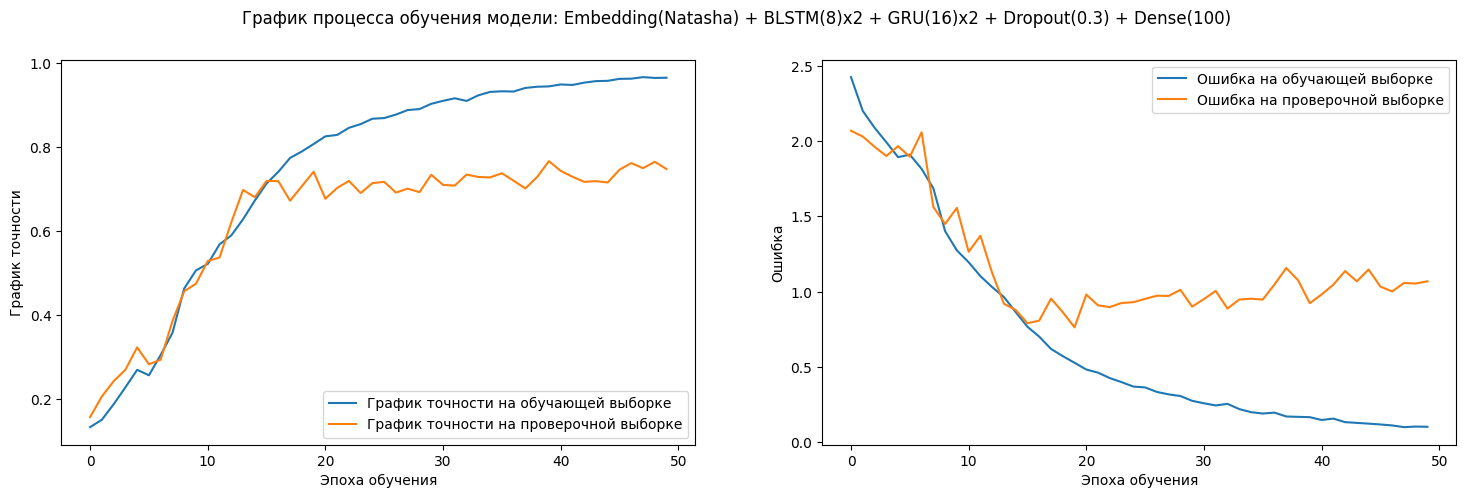

In [ ]:
show_plot(history_mix, 'Embedding(Natasha) + BLSTM(8)x2 + GRU(16)x2 + Dropout(0.3) + Dense(100)')

60/60 [==============================] - 6s 71ms/step


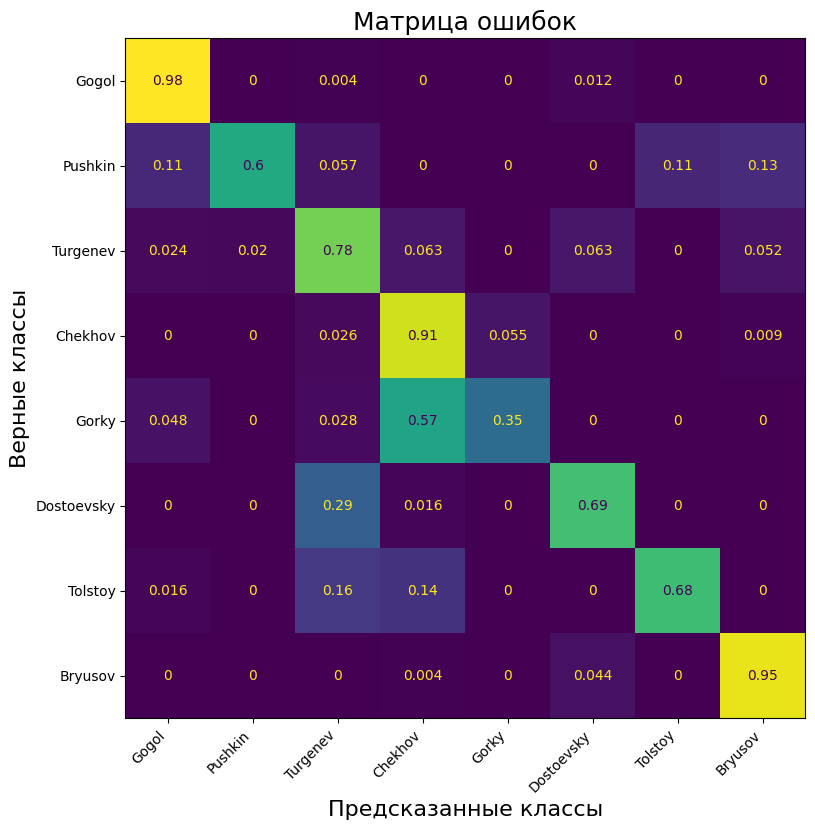


Средняя точность распознавания:  74%


In [ ]:
y_pred_mix = model_MIX.predict(x_valid)
show_confusion_matrix(y_valid, y_pred_mix, CLASS_LIST_BALANCE)

In [ ]:
my_text = '''Наверное все оказывались в такой ситуации, когда произносишь у себя в голове фразу "ох, этот день уже не может стать хуже".
Наш герой, усевшись на мягкое сиденье своего старенького форда, откинул спинку подальше, глубоко вздохнул и произнёс эту волшебную фразу, благодаря которой судьба принимает это пари.
Немного отдышавшись, Сергей вздохнул и попытался вспомнить с какого момента этот день пошёл под откос. Он уставился в одну точку, перематывая и воспроизводя последние 12 часов его бодрствования, но не выдержав этой муки, поток мыслей в его голове благополучно прекратил движение.
Он глубоко вздохнул, завёл машину и двинулся домой. В голове нашего героя существовал целый мир. Он очень любил находиться в этом мире. Чувствовать, представлять, моделировать. За свои 20 лет он развил очень хорошее воображение, которое позволяло ему, засыпая по ночам, смотреть сказки в своей голове.
Его дом находился за городом, Сергей не любил весь этот шум и грязь городов, он предпочитал сидя на крыше своего дома смотреть на звезды или слушать шум ветра.
Сергей никогда не нарушал правила, находясь за рулем, но сегодня был особенный день. Выбравшись из душных оков городских пробок, Сергей, находясь под давлением навалившихся на него проблем, решил что может позволить себе хоть 3 минуты не думать о последствиях и дать себе немного свободы. Педаль газа, под действием сильных, но уставших от тяжелого дня ног, приближалась к резиновому коврику, по грязи которого можно было определить ежедневный маршрут типичного представителя "офисного планктона".
Двигатель пожилого фокуса заревел, набирая обороты. На дороге ни души, казалось наступил апокалипсис и все люди уже давно покинули этот город. Деревья мелькали, сливаясь в зеленую кашу.
Сергей почувствовал себя настолько всемогущим, что даже закрыл глаза. В этот момент он чувствовал что вокруг нет ничего, что он находится в невесомости и никто не сможет разрушить этот мир, в который раз пробудившийся в его голове. Но он ошибался.'''